In [11]:
import numpy as np
import logging
# from joblib import Parallel, delayed
from os.path import exists
import matplotlib.pyplot as plt
from pickle import load, dump

from assignment.util import *
from assignment.TSP import *
from assignment.cooling import *
from assignment.SAMinimizer import *

logging.basicConfig(level = logging.DEBUG)

In [21]:
def nan_arr(arr_size):
    return np.full(arr_size, np.float64("nan"))

def load_n(filename, n):
    with np.load(save_path(filename)) as save_data:
        save_data = np.load(save_path(filename))
        arr_keys = [f"arr_{i}" for i in range(n)]
        arrays = (save_date[key] for key in arr_keys)
        return arrays

In [2]:
DEFAULT_TRANSITIONS = (random_two_opt_transition, Lin2opt)

In [2]:
# logging.basicConfig(level = logging.DEBUG)

In [3]:
cost_eil51, cost_a280, cost_pcb442 = map(first, COST_FUNCTION_PAIRS)
delta_cost_eil51, delta_cost_a280, delta_cost_pcb442 = map(second, COST_FUNCTION_PAIRS)

In [4]:
_, a280_tour = read_tour(OPT_TOUR_FILES[1])
cost_a280(a280_tour)

2586.7696475631606

In [5]:
np.random.seed(0xc0ffee)
cost_function = cost_a280
delta_cost_function = delta_cost_a280
n = delta_cost_function.D.shape[0]
print(n)
T_initial = 100.0
T_final = 0.1

cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt

sim_anneal_system = SAMinimizer(
    mkov_transition,
    delta_cost_a280,
    cooling_schedule,
    np.random.uniform,
    state_constructor)

X0 = np.random.permutation(n)
print(X0)

280
[128 103 205  42  64 180  74 110  50  39 225 264 224   2  81 133 100  80
 257 260 176 113 251   8 130 136  17  65 242  25 263   5  93  68  27 239
 155  96 151 279 204  72   6 275  28 132  12  88 109  40 259  34 129 201
  23 241 221 262 145 166 249  94 134 267 209  76 117  45 139  33   9  69
  90 215 219  91  84 148  98 193 268 168 146 220  51   1 178 227 248 254
 208 234 163  92 237  56  24  61 232 228  26 112 274  21  67 230 141 233
 188 186 191  22  87 144  47 190  70 152 258  62  89 194 162 124 149 211
 158 197 138 140  86 159  11  52 183 222 114 250   7 125  57 214 156 218
 238  48 247  18  66 157 160 202   3 121 212  95 143 107 171 192  54 118
 187  19 147 131 199  14 175 119 213  77 246 244   4  15 165 252  97 206
  49 210 240 142  31 278 273 198 115 223  82  59 195 189 216  29 266 200
 122 203 153 243 135 108  73 126  16 120  44 179 150  30 127 261 174 123
  55 184 181  78 106  38 277  58  43 253  46 207 137 272 265  71 245  20
 235 173 177 231 256 111 170 276  99 161 172  1

In [6]:
sim_anneal_system.run(1000, T_initial, X0, cost_a280, StoppingCriterion.MIN_TEMPERATURE, CostProbing.LATEST_GLOBAL_OPTIMUM, T_final)

In [7]:
print(sim_anneal_system.min_cost)

3221.020789518919


In [8]:
NODE_COUNTS = np.array([51, 280, 442])

## Effect of Temperature on Initial Acceptance Rate

In [4]:
def run_batch(sa_system, batch_size, chain_length, T_initial, *args):
    acceptance_rates = np.full(batch_size, np.float64("nan"))
    min_costs = np.full(batch_size, np.float64("nan"))
    node_count = sa_system.delta_cost.D.shape[0]
    for i in range(batch_size):
        X0 = np.random.permutation(node_count)
        sa_system.run(chain_length, T_initial, X0, *args)
        min_costs[i] = sa_system.min_cost
        acceptance_rates[i] = np.float64(sa_system.acceptance_count)/chain_length
        sa_system.reset()
        
    return min_costs, acceptance_rates

In [30]:
# eil51
cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[0] 
print(node_count)
cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.linspace(1,10, 10)
T_initial_values = c_values * np.sqrt(node_count)


# for parallelization
N_JOBS = 6

rngs = generate_rngs(len(T_initial_values))

batch_size = 10
min_costs_list = []
chain_length = 1000
chain_count = 100
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
npz_filename = "test.npz"
npz_savepath = save_path(npz_filename)


if not exists(npz_filepath):
    # TODO: parallelize this loop
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)

else:
    save_data = np.load(npz_savepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']


51


In [31]:
print(acceptance_rates_list)

[[0.241 0.238 0.257 0.227 0.255 0.247 0.203 0.227 0.239 0.214]
 [0.416 0.392 0.418 0.411 0.444 0.429 0.413 0.462 0.434 0.434]
 [0.556 0.564 0.552 0.545 0.566 0.604 0.578 0.605 0.579 0.568]
 [0.669 0.682 0.671 0.64  0.675 0.643 0.667 0.652 0.671 0.68 ]
 [0.731 0.734 0.743 0.766 0.743 0.69  0.71  0.744 0.74  0.734]
 [0.752 0.784 0.77  0.756 0.763 0.757 0.782 0.788 0.768 0.765]
 [0.818 0.818 0.798 0.813 0.847 0.823 0.823 0.796 0.782 0.805]
 [0.832 0.814 0.827 0.844 0.817 0.834 0.825 0.854 0.818 0.843]
 [0.843 0.859 0.849 0.859 0.855 0.83  0.85  0.85  0.848 0.855]
 [0.862 0.86  0.871 0.862 0.867 0.857 0.855 0.877 0.861 0.864]]


In [32]:
abs_min_costs = np.min(min_cost_list, axis = 1)
mean_acceptance_rates = np.mean(acceptance_rates_list, axis = 1)

In [26]:
min_cost_list.shape

(10, 10)

In [42]:
np.min(abs_min_costs)

435.0180038665094

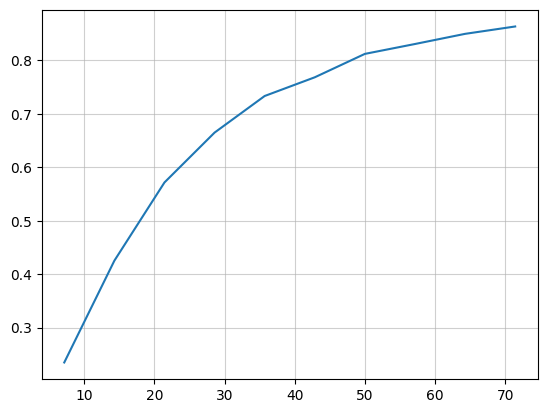

In [46]:
plt.plot(T_initial_values, mean_acceptance_rates)
plt.grid(alpha = 0.6)
plt.show()

In [39]:
[cooling_schedule(T0, chain_count) for T0 in T_initial_values]

[0.04228103568611185,
 0.0845620713722237,
 0.12684310705833554,
 0.1691241427444474,
 0.21140517843055925,
 0.2536862141166711,
 0.29596724980278294,
 0.3382482854888948,
 0.38052932117500665,
 0.4228103568611185]

In [30]:
# eil51
cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[0] 
print(node_count)
cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c_values = np.linspace(1,10, 10)
T_initial_values = c_values * np.sqrt(node_count)


# for parallelization
N_JOBS = 6

rngs = generate_rngs(len(T_initial_values))


batch_size = 10
min_costs_list = []
chain_length = 1000
T_final = 0.05
args = (cost_function, StoppingCriterion.MIN_TEMPERATURE, CostProbing.LATEST_GLOBAL_OPTIMUM, T_final)


sa_systems = [SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)
                for rng in rngs]

min_cost_list = []
acceptance_rates_list = []
# npz_filename = "test_final_temperature.npz"
# npz_savepath = save_path(npz_filename)


if not exists(npz_filepath):
    for i,T0 in enumerate(T_initial_values):
        min_costs, acceptance_rates = run_batch(sa_systems[i], batch_size, chain_length, T0, *args)
        min_cost_list.append(min_costs)
        acceptance_rates_list.append(acceptance_rates)
    min_cost_list = np.array(min_cost_list)
    acceptance_rates_list = np.array(acceptance_rates_list)

else:
    save_data = np.load(npz_savepath)
    min_cost_list, acceptance_rates_list = save_data['arr_0'], save_data['arr_1']

51


In [20]:
# eil51
cost_function, dcost_function = COST_FUNCTION_PAIRS[0]
node_count = cost_function.D.shape[0] 
cr = 0.95
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c = 8
T_initial = c*np.sqrt(node_count)


# for parallelization
N_JOBS = 6

rng = generate_rngs(1)[0]


batch_size = 10
chain_length = 1000
chain_count = 300
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "single_batch_eil51.npz"
npz_filepath = save_path(npz_filename)

min_costs = np.full(batch_size, np.float64('nan'))
acceptance_rates = np.full(batch_size, np.float64('nan'))

if not exists(npz_filepath):
    min_costs, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T_initial, *args)
    np.savez(npz_filepath, min_costs, acceptance_rates)
else:
    save_data = np.load(npz_filepath)
    min_costs, acceptance_rates = save_data['arr_0'], save_data['arr_1']

In [23]:
min_costs

array([494.24997437, 451.76127504, 456.82299706, 457.39624044,
       448.13886882, 462.75267396, 452.12383595, 457.4842705 ,
       488.69090388, 465.05092196])

In [15]:
# eil51
# saves the cost timeseries for one run
# "hairy" plot of costs
rng = generate_rngs(1)[0]

chain_length = 1000
chain_count = 300
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)


sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "single_run_eil51.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_savepath)
    min_costs = save_data['arr_0']

In [22]:
cost_timeseries

array([1681.57235258, 1679.81534532, 1670.14224741, ...,  462.35958031,
        462.35958031,  462.35958031])

In [28]:
# a280
cost_function, dcost_function = COST_FUNCTION_PAIRS[1]
node_count = cost_function.D.shape[0] 
cr = 0.99
cooling_schedule = GeometricCoolingSchedule(cr)
mkov_transition = random_two_opt_transition
state_constructor = Lin2opt


c = 10
T_initial = c*np.sqrt(node_count)


rng = generate_rngs(1)[0]


batch_size = 10
chain_length = 1000
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "single_batch_a280.npz"
npz_filepath = save_path(npz_filename)

min_costs = np.full(batch_size, np.float64('nan'))
acceptance_rates = np.full(batch_size, np.float64('nan'))

if not exists(npz_filepath):
    min_costs, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T_initial, *args)
    np.savez(npz_filepath, min_costs, acceptance_rates)
else:
    save_data = np.load(npz_filepath)
    min_costs, acceptance_rates = save_data['arr_0'], save_data['arr_1']

In [29]:
min_costs

array([3040.24256692, 3060.21167724, 2917.10400487, 3011.0052673 ,
       2924.17102743, 3129.26904846, 3138.53001074, 2845.00978002,
       2902.48212724, 2948.30688929])

In [30]:
# a280
# saves the cost timeseries for one run
# "hairy" plot of costs
rng = generate_rngs(1)[0]

chain_length = 1000
chain_count = 500
args = (cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)


sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "single_run_eil51.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_savepath)
    cost_timeseries = save_data['arr_0']

In [31]:
cost_timeseries

array([32995.28331067, 32801.88351622, 32790.32898145, ...,
        3018.15646294,  3012.03650597,  3012.03650597])

In [32]:
# a280
# same as above
# but final temperature stopping criterion instead
rng = generate_rngs(1)[0]

chain_length = 1000
T_final = 1.0
args = (cost_function, StoppingCriterion.MIN_TEMPERATURE, CostProbing.ACCEPTED, T_final)


sa_system = SAMinimizer(mkov_transition, dcost_function, cooling_schedule, rng.uniform, state_constructor)

npz_filename = "single_run_a280_final_temp.npz"
npz_filepath = save_path(npz_filename)


if not exists(npz_filepath):
    X0 = np.random.permutation(node_count)
    sa_system.run(chain_length, T_initial, X0, cost_function, StoppingCriterion.MKOV_CHAIN_COUNT, CostProbing.ACCEPTED, chain_count)
    cost_timeseries = np.array(sa_system.cost_timeseries)
    np.savez(npz_filepath, cost_timeseries)
else:
    save_data = np.load(npz_savepath)
    cost_timeseries = save_data['arr_0']

In [34]:
np.min(cost_timeseries)

3105.1727812297277

## Acceptance Rate v/s Temperature
Given the number of cities $n$, we set the initial temperature $T_0 = cn$, where $c$ is some constant. We would
like to observe how the initial acceptance rate $\eta$ varies in the first chain as a function of the initial temperature. Do we want to ensure that the Markov chain converges to a stationary acceptance rate? I should really be doing some literature review on this, man.

We have the following tunable parameters/hyper-parameters
- chain length
- initial temperature values

Do we want to first ensure that the initial Markov chain converges? We would have to observe the mean of the first chain. Do we observe it for randomized initial states? But then the neighbours would be different.

### EIL 51
Starting with some random initial temperature value, we observe the acceptance rate for one Markov chain

In [5]:
# cost functions for eil51
cost_func, dcost_func = COST_FUNCTION_PAIRS[0]
# node count shoule be 51
node_count = first(cost_func.D.shape)
assert node_count == 51,"Cost function assignment is fucked."

# we simulate only one chain
stopping_condition = StoppingCriterion.MKOV_CHAIN_COUNT
chain_count = 1
# does not matter as we are doing only one chain
cooling_schedule = GeometricCoolingSchedule(0.5)  
chain_length_values = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000], dtype = np.int32)

# some initial temperature, we could study the acceptance rates
c = 5
T0 = c * np.sqrt(node_count)
batch_size = 10
npz_filename = "prelim_acceptance_rates_eil51.npz"
npz_filepath = save_path(npz_filename)
transition, state_constructor = DEFAULT_TRANSITIONS

rngs = generate_rngs(len(chain_length_values))

args = (cost_func, stopping_condition, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)

acceptance_rates_list = []
if not exists(npz_filepath):
    for i, chain_length in enumerate(chain_length_values):
        sa_system = SAMinimizer(transition, dcost_func, cooling_schedule, rngs[i].uniform, state_constructor)
        _, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T0, *args)
        acceptance_rates_list.append(acceptance_rates)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        acceptance_rates_list = save_data['arr_0']

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

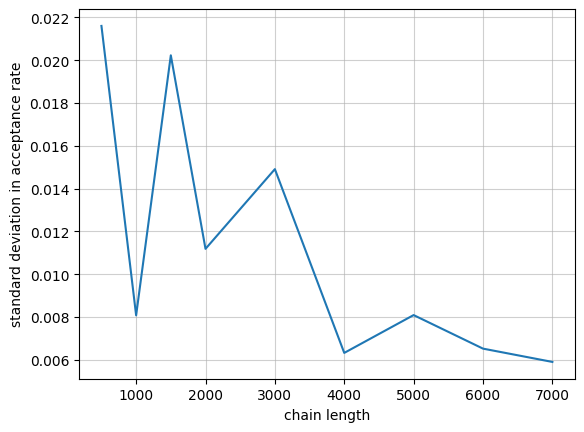

In [6]:
# TODO: change to mean +- stddev (using `fill_between`)
plt.plot(chain_length_values, std_acc_rates)
plt.xlabel("chain length")
plt.ylabel("standard deviation in acceptance rate")
plt.grid(alpha = 0.6)
plt.show()

**Judging from the results of the above graph, a chain length of $4000$ seems goed genoeg.**
Nevertheless, this is subject to change based on results on experiments with the chain length

In [7]:
c_values = np.linspace(1.,10.,10)
c_values
T0_values = c_values * np.sqrt(node_count)
chain_length = 4000
chain_count = 1

rngs = generate_rngs(len(T0_values), seed = 0xbeef)

args = (cost_func, stopping_condition, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)
npz_filename = "eil51_acceptance_rates.npz"
npz_filepath  = save_path(npz_filename)

acceptance_rates_list = []

if not exists(npz_filepath):
    for i, T0 in enumerate(T0_values):
        sa_system = SAMinimizer(transition, dcost_func, cooling_schedule, rngs[i].uniform, state_constructor)
        _, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T0, *args)
        acceptance_rates_list.append(acceptance_rates)
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        acceptance_rates_list = save_data['arr_0']

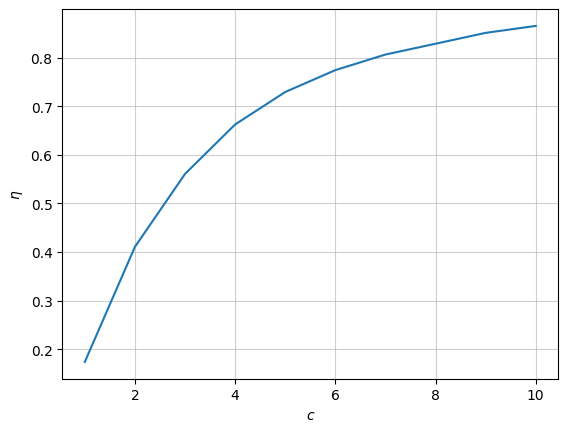

In [8]:
mean_acceptance_rates = np.mean(acceptance_rates_list, axis = 1)
plt.plot(c_values, mean_acceptance_rates)
plt.xlabel("$c$")
plt.ylabel("$\\eta$")
plt.grid(alpha = 0.6)
plt.show()

### Convergence Behaviour for different $T_0$ values
With chain length $4000$ and these $c$-values, we observe the convergence behaviour for $T_{\text{final}} = 1$ (say)

In [19]:
c_values = np.linspace(1.,10.,10)
c_values
T0_values = c_values * np.sqrt(node_count)
chain_length = 4000
cost_func, dcost_func = COST_FUNCTION_PAIRS[0]
node_count = first(cost_func.D.shape)
assert node_count == 51, "Lol"

cr = 0.975
cooling_schedule = GeometricCoolingSchedule(cr)

rngs = generate_rngs(len(T0_values), seed = 0xbeef)

stopping_condition = StoppingCriterion.MIN_TEMPERATURE
T_final = 1.0

args = (cost_func, stopping_condition, CostProbing.ACCEPTED, T_final)
npz_filename = "eil51_T0_convergence.npz"
npz_filepath  = save_path(npz_filename)

min_costs_list = []

batch_size = 10

if not exists(npz_filepath):
    for i, T0 in enumerate(T0_values):
        sa_system = SAMinimizer(transition, dcost_func, cooling_schedule, rngs[i].uniform, state_constructor)
        min_costs, _ = run_batch(sa_system, batch_size, chain_length, T0, *args)
        min_costs_list.append(min_costs)
        print(f"Done with {i+1} batches.")
    min_costs_list = np.array(min_costs_list)
    np.savez(npz_filepath, min_costs_list)
else:
    with np.load(npz_filepath) as save_data:
        min_costs_list = save_data['arr_0']

Done with 1 batches.
Done with 2 batches.
Done with 3 batches.
Done with 4 batches.
Done with 5 batches.
Done with 6 batches.
Done with 7 batches.
Done with 8 batches.
Done with 9 batches.
Done with 10 batches.


In [20]:
np.mean(min_costs_list, axis =1)

array([453.91341327, 445.28477338, 455.35851549, 454.77534916,
       459.83938453, 451.63016391, 461.33664081, 455.95514888,
       450.81730427, 453.73352381])

In [21]:
mean_min_costs = np.mean(min_costs_list, axis = 1)
std_min_costs = np.std(min_costs_list, axis = 1)

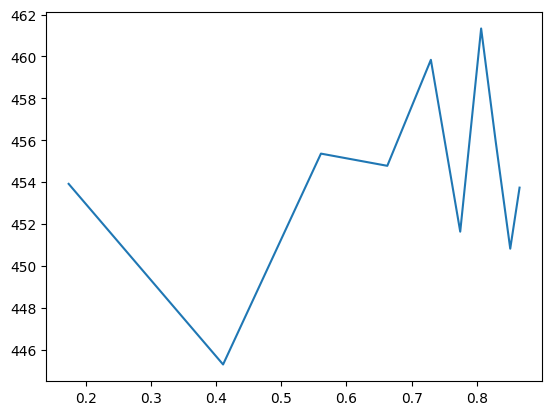

In [24]:
plt.plot(mean_acceptance_rates, mean_min_costs)
plt.show()

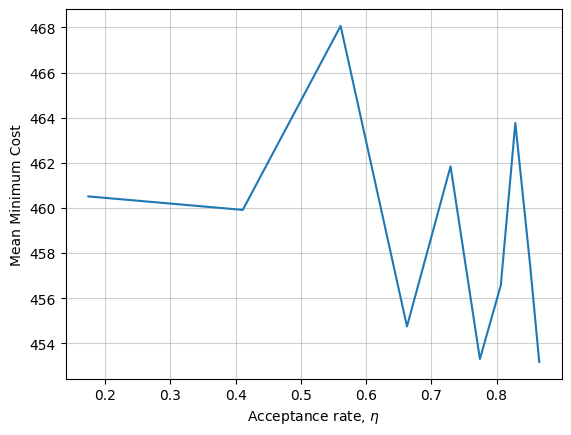

In [18]:
plt.plot(mean_acceptance_rates, mean_min_costs)
plt.xlabel("Acceptance rate, $\\eta$")
plt.ylabel("Mean Minimum Cost")
plt.grid(alpha = 0.6)
plt.show()

## a280
Repeating the above "experiments" with the `a280` data set

In [12]:
# cost functions for a280
cost_func, dcost_func = COST_FUNCTION_PAIRS[1]
# node count shoule be 280
node_count = first(cost_func.D.shape)

assert node_count == 280,"Cost function assignment is fucked."

# we simulate only one chain
stopping_condition = StoppingCriterion.MKOV_CHAIN_COUNT
chain_count = 1
# does not matter as we are doing only one chain
cooling_schedule = GeometricCoolingSchedule(0.5)  
chain_length_values = np.array([500, 1000, 1500, 2000, 3000, 4000, 5000, 6000, 7000], dtype = np.int32)

# some initial temperature, we could study the acceptance rates
c = 5
T0 = c * np.sqrt(node_count)
batch_size = 10
npz_filename = "prelim_acceptance_rates_a280.npz"
npz_filepath = save_path(npz_filename)
transition, state_constructor = DEFAULT_TRANSITIONS

rngs = generate_rngs(len(chain_length_values))

args = (cost_func, stopping_condition, CostProbing.LATEST_GLOBAL_OPTIMUM, chain_count)

acceptance_rates_list = []
if not exists(npz_filepath):
    for i, chain_length in enumerate(chain_length_values):
        sa_system = SAMinimizer(transition, dcost_func, cooling_schedule, rngs[i].uniform, state_constructor)
        _, acceptance_rates = run_batch(sa_system, batch_size, chain_length, T0, *args)
        acceptance_rates_list.append(acceptance_rates)
        logging.debug(f"Done with {i+1} batches")
    acceptance_rates_list = np.array(acceptance_rates_list)
    np.savez(npz_filepath, acceptance_rates_list)
else:
    with np.load(npz_filepath) as save_data:
        acceptance_rates_list = save_data['arr_0']

mean_acc_rates = np.mean(acceptance_rates_list, axis = 1)
std_acc_rates = np.std(acceptance_rates_list, axis = 1)

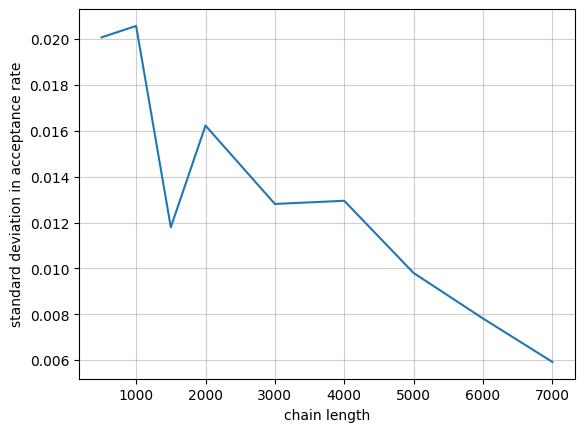

In [48]:
# TODO: change to mean +- stddev (using `fill_between`)
plt.plot(chain_length_values, std_acc_rates)
plt.xlabel("chain length")
plt.ylabel("standard deviation in acceptance rate")
plt.grid(alpha = 0.6)
plt.show()

## Test Different Cooling Schemes
### Geometric Cooling
\begin{equation}
T_k = cT_{k-1},\quad c \in (0,1)
\end{equation}

First we coarse-grain over $(0.8, 0.9)$, and then "fine grain" over, say, $(0.9, 0.9999)$.

In [3]:
# First, coarse graining over [0.8, 0.9]
cr_values = np.linspace(0.8, 0.9, 11)
cr_values

array([0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 ])